Column description:\
**city** - the name of the city where the property is located\
**type** - type of the building\
**squareMeters** - the size of the apartment in square meters\
**rooms** - number of rooms in the apartment\
**floor / floorCount** - the floor where the apartment is located and the total number of floors in the building\
**buildYear** - the year when the building was built\
**latitude, longitude** - geo coordinate of the property\
**centreDistance** - distance from the city centre in km\
**poiCount** - number of points of interest in 500m range from the apartment (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)\
**[poiName]Distance** - distance to the nearest point of interest (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)\
**ownership** - the type of property ownership\
**condition** - the condition of the apartment\
**has[features]** - whether the property has key features such as assigned parking space, balcony, elevator, security, storage room\
**price** - offer price in Polish Zloty

apartments_pl_YYYY_MM.csv: sale price


In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

In [2]:
path = "/content/drive/MyDrive/Data Analysis/Apartments-Prices-in-Poland/apartments_pl_2024_06.csv"

df = pd.read_csv(path)

In [3]:
df.head()

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,811891f98a870dfd6e414374a0a85560,szczecin,blockOfFlats,47.00,2.0,6.0,12.0,1981.0,53.428544,14.552812,...,0.085,condominium,concreteSlab,NaN,no,yes,yes,no,yes,449000
1,adaf636d0c44d8d9325bce42403eefee,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,14.516844,...,0.668,condominium,brick,premium,yes,yes,no,no,no,950000
2,9b957bd60885a469c96f17b58a914f4b,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,NaN,53.443096,14.561348,...,0.229,udział,brick,premium,yes,yes,no,no,no,1099000
3,74fef2ff7135bc70797a3fbfd7d44ed6,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,14.541200,...,0.388,cooperative,brick,NaN,yes,no,no,yes,yes,380000
4,77cc78c75b0d09bf84d6d3124a28803c,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,14.557811,...,0.178,condominium,brick,premium,yes,yes,yes,yes,yes,799000


In [4]:
fig = px.scatter_mapbox(
    df,
    lat=df['latitude'],
    lon=df['longitude'],
    width=600,
    height=600,
    color='price',
    hover_data=["price"],
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21501 entries, 0 to 21500
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    21501 non-null  object 
 1   city                  21501 non-null  object 
 2   type                  17104 non-null  object 
 3   squareMeters          21501 non-null  float64
 4   rooms                 21501 non-null  float64
 5   floor                 17928 non-null  float64
 6   floorCount            21292 non-null  float64
 7   buildYear             18121 non-null  float64
 8   latitude              21501 non-null  float64
 9   longitude             21501 non-null  float64
 10  centreDistance        21501 non-null  float64
 11  poiCount              21501 non-null  float64
 12  schoolDistance        21490 non-null  float64
 13  clinicDistance        21438 non-null  float64
 14  postOfficeDistance    21481 non-null  float64
 15  kindergartenDistanc

Drop the columns that I won't be using for sure

In [6]:
df.drop(columns=['city', 'id', 'type', 'floorCount', 'buildYear', 'ownership', 'condition', 'buildingMaterial'], inplace=True)
df.head()

,squareMeters,rooms,floor,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,47.00,2.0,6.0,53.428544,14.552812,0.79,67.0,0.288,0.285,0.268,0.245,0.068,0.593,0.085,no,yes,yes,no,yes,449000
1,88.22,3.0,1.0,53.449093,14.516844,4.09,0.0,0.509,1.039,0.998,0.676,0.661,1.192,0.668,yes,yes,no,no,no,950000
2,117.00,5.0,4.0,53.443096,14.561348,2.19,10.0,0.216,0.611,0.743,0.280,0.298,1.522,0.229,yes,yes,no,no,no,1099000
3,33.31,1.0,1.0,53.436100,14.541200,1.93,39.0,0.073,0.326,0.284,0.089,0.180,0.041,0.388,yes,no,no,yes,yes,380000
4,56.00,3.0,7.0,53.447465,14.557811,2.68,10.0,0.268,0.771,0.676,0.260,0.322,1.643,0.178,yes,yes,yes,yes,yes,799000


One of the most important factors will be apartment's area. Let's check if there are any outliers.

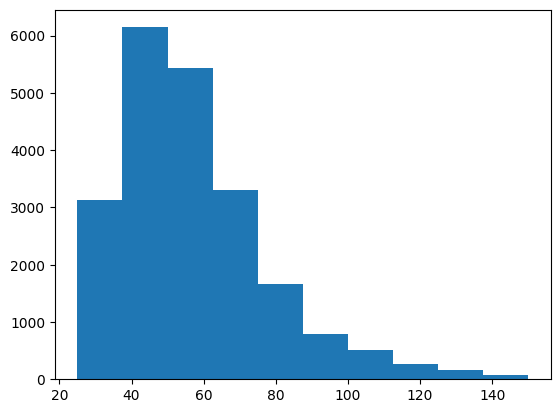

In [7]:
plt.hist(df['squareMeters']);

In [8]:
df['squareMeters'].describe()

,squareMeters
count,21501.000000
mean,56.968572
std,20.617717
min,25.000000
25%,42.690000
50%,52.810000
75%,66.300000
max,150.000000


Use IQR to remove outliers from 'squareMeters' column

In [9]:
IQR = df['squareMeters'].quantile(0.75) - df['squareMeters'].quantile(0.25)
df = df.loc[df['squareMeters'] < (df['squareMeters'].quantile(0.75) + (1.5 * IQR))]

Delete null values

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-10-5110ff77c3d8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   squareMeters          16013 non-null  float64
 1   rooms                 16013 non-null  float64
 2   floor                 16013 non-null  float64
 3   latitude              16013 non-null  float64
 4   longitude             16013 non-null  float64
 5   centreDistance        16013 non-null  float64
 6   poiCount              16013 non-null  float64
 7   schoolDistance        16013 non-null  float64
 8   clinicDistance        16013 non-null  float64
 9   postOfficeDistance    16013 non-null  float64
 10  kindergartenDistance  16013 non-null  float64
 11  restaurantDistance    16013 non-null  float64
 12  collegeDistance       16013 non-null  float64
 13  pharmacyDistance      16013 non-null  float64
 14  hasParkingSpace       16013 non-null  object 
 15  hasBalcony         

Convert all the 'yes' and 'no' values to 0s and 1s

In [12]:
df.replace({'yes': 1, 'no': 0}, inplace=True)

<ipython-input-12-5c7aa3790328>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-12-5c7aa3790328>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df.head()

,squareMeters,rooms,floor,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,47.00,2.0,6.0,53.428544,14.552812,0.79,67.0,0.288,0.285,0.268,0.245,0.068,0.593,0.085,0,1,1,0,1,449000
1,88.22,3.0,1.0,53.449093,14.516844,4.09,0.0,0.509,1.039,0.998,0.676,0.661,1.192,0.668,1,1,0,0,0,950000
2,33.31,1.0,1.0,53.436100,14.541200,1.93,39.0,0.073,0.326,0.284,0.089,0.180,0.041,0.388,1,0,0,1,1,380000
3,56.00,3.0,7.0,53.447465,14.557811,2.68,10.0,0.268,0.771,0.676,0.260,0.322,1.643,0.178,1,1,1,1,1,799000
4,68.61,3.0,4.0,53.456213,14.583222,3.94,7.0,0.139,1.336,0.926,0.930,0.071,0.786,0.304,0,1,0,0,1,599000


Check for multicolinearity

<Axes: >

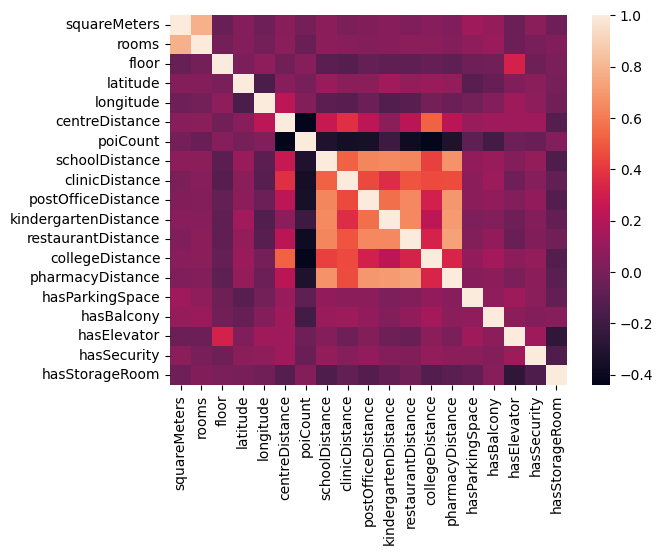

In [14]:
corr = df.select_dtypes('number').drop(columns='price').corr()
sns.heatmap(corr)

Drop 'rooms' column as it's highly correlated with 'square meters'

In [15]:
df.drop(columns='rooms', inplace=True)

# Build model

In [16]:
target = 'price'
X = df.drop(columns=target)
y = df[target]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12810, 18)
y_train shape: (12810,)
X_test shape: (3203, 18)
y_test shape: (3203,)


Calculate baseline MAE

In [18]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline, y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 798421.4105386417
Baseline MAE: 276382.88650801574


Fit model Linear Regression

In [93]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [96]:
y_train_pred = model.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train MAE:", y_train_mae)

Train MAE: 181386.04610766025


In [97]:
y_test_pred = model.predict(X_test)
y_test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", y_test_mae)

Test MAE: 184120.6698752528


In [98]:
model.coef_

array([  13771.25600041,   -5041.96008918,   10680.10483011,
         40359.29426594,   16722.14184027,    3166.21417951,
         51984.64288402,  -49705.82069392,   36094.09462415,
         17430.98704534, -181758.68667808,  -20340.49485739,
        116365.99601251,   51309.31668393,   11612.31106157,
        140858.35856214,   21490.48044937,  -78040.81230098])

Fit model Ridge

In [19]:
new_model = Ridge()
new_model.fit(X_train, y_train)

Ridge()

In [20]:
y_train_pred = new_model.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train MAE:", y_train_mae)

Train MAE: 181382.15291123136


In [21]:
y_test_pred = new_model.predict(X_test)
y_test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", y_test_mae)

Test MAE: 184119.6419821175


In [22]:
new_model.coef_

array([  13771.31319543,   -5040.11043537,   10679.5472518 ,
         40363.97033737,   16722.16806711,    3166.74763197,
         51920.67205155,  -49700.75865481,   36076.09516683,
         17438.72014787, -181351.33838464,  -20332.55007775,
        116035.27798253,   51302.11685926,   11608.93034913,
        140827.54756136,   21497.10052395,  -78044.1629338 ])